In [1]:
!pip install git+https://github.com/openai/CLIP.git scikit-learn matplotlib


import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomAffine, ColorJitter
import clip  # OpenAI CLIP: Radford et al., "Learning Transferable Visual Models From Natural Language Supervision" (2021)
import matplotlib.pyplot as plt

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v39e4exb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v39e4exb
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

# Source: OpenAI CLIP repository - https://github.com/openai/CLIP
model_name = "ViT-B/32"
print(f"Loading CLIP model: {model_name}")
clip_model, preprocess_clip = clip.load(model_name, device=device)

clip_model = clip_model.float()

Using device: cuda
Loading CLIP model: ViT-B/32


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 62.1MiB/s]


In [3]:
LABELS_PATH = "/kaggle/input/data/Data_Entry_2017.csv"
IMG_BASE_DIR = "/kaggle/input/data"
TRAIN_LIST = "/kaggle/input/data/train_val_list.txt"
TEST_LIST = "/kaggle/input/data/test_list.txt"

df = pd.read_csv(LABELS_PATH)
# Source: NIH Chest X-ray Dataset - Wang et al., "ChestX-ray8: Hospital-scale Chest X-ray Database 
# and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases" (2017)
DISEASES = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", 
            "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", 
            "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
disease_to_idx = {d: i for i, d in enumerate(DISEASES)}

def read_split_list(txt_path):
    """Read image filenames from a text file."""
    with open(txt_path, "r") as f:
        return [line.strip() for line in f.readlines()]

print("Loading data splits...")
train_val_fnames = read_split_list(TRAIN_LIST)
test_fnames = read_split_list(TEST_LIST)

random.shuffle(train_val_fnames)
total_train_val = len(train_val_fnames) 
train_size = int((75312/86524) * total_train_val) 
train_fnames = train_val_fnames[:train_size]
val_fnames = train_val_fnames[train_size:]

total_fnames_count = len(train_val_fnames) + len(test_fnames)
print(f"Total images: {total_fnames_count}")
print(f"Training images: {len(train_fnames)} ({len(train_fnames)/total_fnames_count:.2%})")
print(f"Validation images: {len(val_fnames)} ({len(val_fnames)/total_fnames_count:.2%})")
print(f"Test images: {len(test_fnames)} ({len(test_fnames)/total_fnames_count:.2%})")



Loading data splits...
Total images: 112120
Training images: 75312 (67.17%)
Validation images: 11212 (10.00%)
Test images: 25596 (22.83%)


In [4]:
def parse_labels(label_str):
    """Convert a pipe-separated string of labels to a multi-hot vector.
    Format follows NIH Chest X-ray dataset convention."""
    labels = label_str.split('|')
    multi_hot = np.zeros(len(DISEASES), dtype=np.float32)
    for lbl in labels:
        if lbl in disease_to_idx:
            multi_hot[disease_to_idx[lbl]] = 1.0
    return multi_hot

print("Creating label mapping...")
image_to_multilabel = {row["Image Index"]: parse_labels(row["Finding Labels"]) 
                       for _, row in df.iterrows()}

# Similar approach used in Rajpurkar et al., "CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning" (2017)
class_counts = np.zeros(len(DISEASES))
total_images = 0
for labels in image_to_multilabel.values():
    class_counts += labels
    total_images += 1

class_weights = total_images / (class_counts * len(DISEASES))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class frequencies:")
for disease, count in zip(DISEASES, class_counts):
    print(f"{disease}: {count} ({count/total_images:.2%})")

Creating label mapping...
Class frequencies:
Atelectasis: 11559.0 (10.31%)
Cardiomegaly: 2776.0 (2.48%)
Effusion: 13317.0 (11.88%)
Infiltration: 19894.0 (17.74%)
Mass: 5782.0 (5.16%)
Nodule: 6331.0 (5.65%)
Pneumonia: 1431.0 (1.28%)
Pneumothorax: 5302.0 (4.73%)
Consolidation: 4667.0 (4.16%)
Edema: 2303.0 (2.05%)
Emphysema: 2516.0 (2.24%)
Fibrosis: 1686.0 (1.50%)
Pleural_Thickening: 3385.0 (3.02%)
Hernia: 227.0 (0.20%)


In [5]:
def build_image_path_dict(base_dir):
    """Build a dictionary mapping image filenames to their full paths."""
    image_path_dict = {}
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".png"):
                image_path_dict[file] = os.path.join(root, file)
    return image_path_dict

print("Building image path dictionary...")
image_path_dict = build_image_path_dict(IMG_BASE_DIR)
print(f"Total images found: {len(image_path_dict)}")

train_data = [(image_path_dict[fname], image_to_multilabel[fname]) 
              for fname in train_fnames if fname in image_to_multilabel and fname in image_path_dict]
val_data = [(image_path_dict[fname], image_to_multilabel[fname]) 
            for fname in val_fnames if fname in image_to_multilabel and fname in image_path_dict]
test_data = [(image_path_dict[fname], image_to_multilabel[fname]) 
             for fname in test_fnames if fname in image_to_multilabel and fname in image_path_dict]

print(f"Train Data: {len(train_data)}")
print(f"Validation Data: {len(val_data)}")
print(f"Test Data: {len(test_data)}")

Building image path dictionary...
Total images found: 112120
Train Data: 75312
Validation Data: 11212
Test Data: 25596


In [6]:
class NIHMultiLabelDataset(Dataset):
    """Dataset for NIH Chest X-ray images with multi-label classification.
    Custom PyTorch Dataset implementation following standard PyTorch patterns:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"""
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, multi_hot = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(multi_hot, dtype=torch.float32)

# Similar augmentation techniques from Bressem et al., "Highly accurate 
# disease detection by adversarial training of deep neural networks for chest radiography" (2020)
train_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Following CLIP's preprocessing pipeline from OpenAI:
# https://github.com/openai/CLIP/blob/main/clip/clip.py
val_test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
              std=[0.26862954, 0.26130258, 0.27577711])
])

train_dataset = NIHMultiLabelDataset(train_data, transform=train_transform)
val_dataset = NIHMultiLabelDataset(val_data, transform=val_test_transform)
test_dataset = NIHMultiLabelDataset(test_data, transform=val_test_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
class NIHChestXrayMultiLabel(nn.Module):
    """Enhanced model for transfer learning from CLIP to chest X-ray classification.
    Follows transfer learning approach similar to:
    - Raghu et al., "Transfusion: Understanding Transfer Learning for Medical Imaging" (2019)
    - Selectively unfreezing technique from Howard & Ruder, "Universal Language Model Fine-tuning for Text Classification" (2018)
    - Combined with CLIP visual encoder: Radford et al. (2021)"""
    def __init__(self, clip_model, num_labels, unfreeze_layers=0):
        super().__init__()
        self.clip_visual = clip_model.visual       
        if unfreeze_layers > 0:
            for param in self.clip_visual.parameters():
                param.requires_grad = False     
            # Progressive unfreezing technique adapted from:
            # Howard & Ruder, "Universal Language Model Fine-tuning" (2018)
            if hasattr(self.clip_visual, 'transformer'):
                for i in range(len(self.clip_visual.transformer.resblocks) - unfreeze_layers, 
                              len(self.clip_visual.transformer.resblocks)):
                    for param in self.clip_visual.transformer.resblocks[i].parameters():
                        param.requires_grad = True                
            if hasattr(self.clip_visual, 'ln_post'):
                for param in self.clip_visual.ln_post.parameters():
                    param.requires_grad = True
                    
            if hasattr(self.clip_visual, 'proj'):
                if isinstance(self.clip_visual.proj, nn.Parameter):
                    self.clip_visual.proj.requires_grad = True
                elif hasattr(self.clip_visual.proj, 'parameters'):
                    for param in self.clip_visual.proj.parameters():
                        param.requires_grad = True
        else:
            for param in self.clip_visual.parameters():
                param.requires_grad = False
        
        feature_dim = clip_model.visual.output_dim
        # MLP with LayerNorm and GELU follows:
        # Dosovitskiy et al., "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (2020)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.LayerNorm(feature_dim),  
            nn.GELU(),                 
            nn.Dropout(0.3),           
            nn.Linear(feature_dim, feature_dim // 2),
            nn.LayerNorm(feature_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(feature_dim // 2, num_labels)
        )
        
        # Initialization technique from He et al., "Delving Deep into Rectifiers" (2015)
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.clip_visual(x).float()  # Explicit conversion to float
        return self.classifier(features)

In [8]:
#Focal Loss from: Lin et al., "Focal Loss for Dense Object Detection" (2017)
class FocalBCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, alpha=0.25):
        super().__init__()
        self.weight = weight
        self.gamma = gamma  
        self.alpha = alpha  
        
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        if self.weight is not None:
            bce_loss = bce_loss * self.weight.view(1, -1)
        
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - p_t) ** self.gamma
        
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        focal_loss = alpha_t * focal_factor * bce_loss
        
        return focal_loss.mean()

In [9]:
UNFREEZE_LAYERS = 3  

print(f"Creating model with {UNFREEZE_LAYERS} unfrozen encoder layers...")
model = NIHChestXrayMultiLabel(clip_model, len(DISEASES), unfreeze_layers=UNFREEZE_LAYERS).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

criterion = FocalBCEWithLogitsLoss(weight=class_weights, gamma=2.0, alpha=0.25)

# Discriminative fine-tuning approach from:Howard & Ruder, "Universal Language Model Fine-tuning for Text Classification" (2018)
encoder_params = []
classifier_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if name.startswith('clip_visual'):
            encoder_params.append(param)
        else:
            classifier_params.append(param)

if encoder_params:  
    optimizer = optim.AdamW([
        {'params': encoder_params, 'lr': 1e-5},  # Lower learning rate for fine-tuning
        {'params': classifier_params, 'lr': 1e-4}  # Higher learning rate for classifier
    ], weight_decay=1e-2)  # Weight decay for regularization
else:
    optimizer = optim.AdamW(classifier_params, lr=1e-4, weight_decay=1e-2)

# ReduceLROnPlateau follows approach from many medical imaging papers including Irvin et al., "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison" (2019)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

Creating model with 3 unfrozen encoder layers...
Trainable parameters: 22,057,486 (24.99% of total)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
num_epochs = 10  
best_val_auc = 0.0
patience_counter = 0
patience_limit = 5  
history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'lr': []
}

In [11]:
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    

    current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]
    history['lr'].append(current_lrs[0] if len(current_lrs) > 1 else current_lrs[0])
    

    model.eval()
    val_loss = 0.0
    val_targets, val_outputs = [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            val_targets.append(labels.cpu().numpy())
            val_outputs.append(logits.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    
    val_targets = np.concatenate(val_targets, axis=0)
    val_outputs = np.concatenate(val_outputs, axis=0)
    val_probs = 1.0 / (1.0 + np.exp(-val_outputs))  # Sigmoid activation
    

    # Rajpurkar et al., "CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning" (2017)
    disease_aucs = []
    for i in range(len(DISEASES)):
        
        if np.sum(val_targets[:, i]) > 0 and np.sum(val_targets[:, i]) < len(val_targets):
            disease_aucs.append(roc_auc_score(val_targets[:, i], val_probs[:, i]))
        else:
            disease_aucs.append(0.5)  
    
    val_auc = np.mean(disease_aucs)
    history['val_auc'].append(val_auc)
    
    
    scheduler.step(val_auc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    for i, param_group in enumerate(optimizer.param_groups):
        group_name = "Encoder" if i == 0 and len(optimizer.param_groups) > 1 else "Classifier"
        print(f"  {group_name} learning rate: {param_group['lr']:.2e}")
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
        }, "best_nih_chest_xray_model.pth")
        print(f"Model saved with validation AUC: {best_val_auc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"Early stopping after {patience_limit} epochs without improvement")
            break

Starting training...


Validating: 100%|██████████| 351/351 [01:45<00:00,  3.32it/s]


Epoch 1/10 - Train Loss: 0.0477, Val Loss: 0.0286, Val AUC: 0.7078
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7078


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.37it/s]


Epoch 2/10 - Train Loss: 0.0299, Val Loss: 0.0272, Val AUC: 0.7316
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7316


Validating: 100%|██████████| 351/351 [01:49<00:00,  3.20it/s]


Epoch 3/10 - Train Loss: 0.0274, Val Loss: 0.0256, Val AUC: 0.7504
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7504


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 4/10 - Train Loss: 0.0261, Val Loss: 0.0263, Val AUC: 0.7552
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7552


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.35it/s]


Epoch 5/10 - Train Loss: 0.0252, Val Loss: 0.0249, Val AUC: 0.7679
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7679


Validating: 100%|██████████| 351/351 [01:46<00:00,  3.29it/s]


Epoch 6/10 - Train Loss: 0.0246, Val Loss: 0.0248, Val AUC: 0.7690
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7690


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 7/10 - Train Loss: 0.0240, Val Loss: 0.0253, Val AUC: 0.7737
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7737


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 8/10 - Train Loss: 0.0236, Val Loss: 0.0242, Val AUC: 0.7769
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7769


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 9/10 - Train Loss: 0.0232, Val Loss: 0.0239, Val AUC: 0.7788
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7788


Validating: 100%|██████████| 351/351 [01:44<00:00,  3.36it/s]


Epoch 10/10 - Train Loss: 0.0231, Val Loss: 0.0244, Val AUC: 0.7825
  Encoder learning rate: 1.00e-05
  Classifier learning rate: 1.00e-04
Model saved with validation AUC: 0.7825


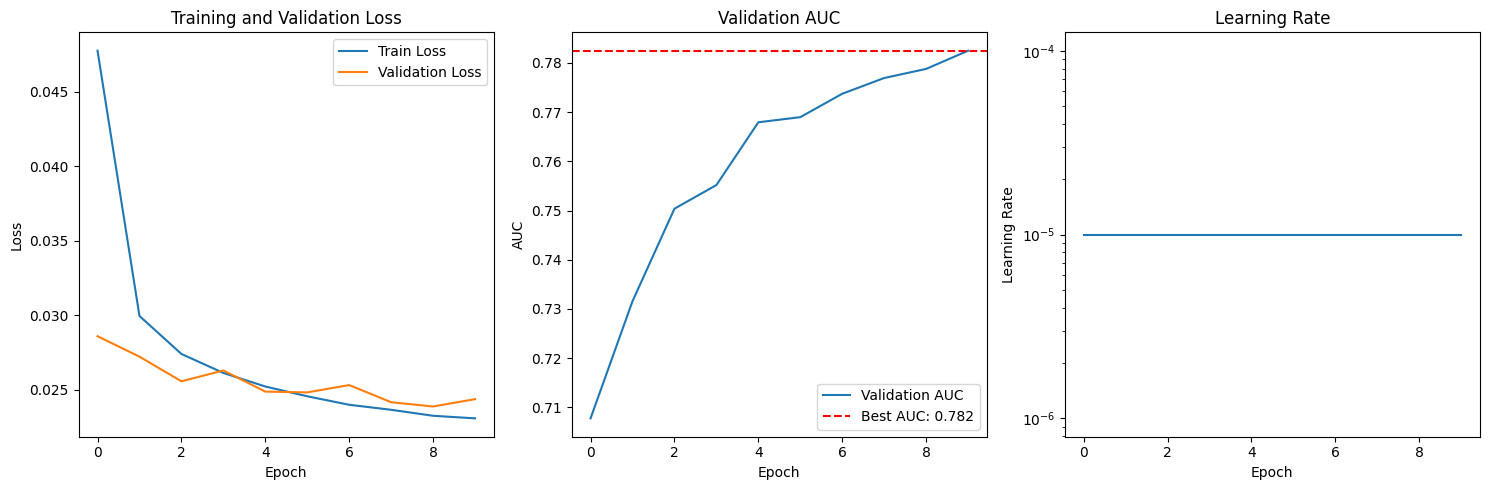

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(history['val_auc'], label='Validation AUC')
plt.axhline(y=best_val_auc, color='r', linestyle='--', 
           label=f'Best AUC: {best_val_auc:.3f}')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC')

# Add learning rate plot
plt.subplot(1, 3, 3)
plt.plot(history['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.title('Learning Rate')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [13]:
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint = torch.load("best_nih_chest_xray_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation AUC: {checkpoint['val_auc']:.4f}")

Loading best model for evaluation...


/tmp/ipykernel_31/94099268.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_nih_chest_xray_model.pth")


Loaded model from epoch 10 with validation AUC: 0.7825


In [ ]:
#ZERO-SHOT AND FEW-SHOT COMMON DISEASE (NIH CHEST X-RAY)
class NIHChestXrayMultiLabel(nn.Module):
    def __init__(self, clip_model, num_labels, unfreeze_layers=0):
        super().__init__()
        self.clip_visual = clip_model.visual
        
        for param in self.clip_visual.parameters():
            param.requires_grad = False
            
        feature_dim = clip_model.visual.output_dim
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim // 2),
            nn.LayerNorm(feature_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(feature_dim // 2, num_labels)
        )
    
    def forward(self, x):
        features = self.clip_visual(x).float()
        return self.classifier(features)

class NIHMultiLabelDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, multi_hot = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(multi_hot, dtype=torch.float32)

import clip
model_name = "ViT-B/32"
print(f"Loading CLIP model: {model_name}")
clip_model, preprocess_clip = clip.load(model_name, device=device)
clip_model = clip_model.float()

DISEASES = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", 
            "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", 
            "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
disease_to_idx = {d: i for i, d in enumerate(DISEASES)}

model = NIHChestXrayMultiLabel(clip_model, len(DISEASES)).to(device)

print("Loading best model weights...")
checkpoint = torch.load("best_nih_chest_xray_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation AUC: {checkpoint['val_auc']:.4f}")

LABELS_PATH = "/kaggle/input/data/Data_Entry_2017.csv"
IMG_BASE_DIR = "/kaggle/input/data"
TRAIN_LIST = "/kaggle/input/data/train_val_list.txt"
TEST_LIST = "/kaggle/input/data/test_list.txt"

df = pd.read_csv(LABELS_PATH)

def read_split_list(txt_path):
    """Read image filenames from a text file."""
    with open(txt_path, "r") as f:
        return [line.strip() for line in f.readlines()]

train_val_fnames = read_split_list(TRAIN_LIST)
test_fnames = read_split_list(TEST_LIST)

random.shuffle(train_val_fnames)
train_fnames = train_val_fnames[:int(0.8 * len(train_val_fnames))]
val_fnames = train_val_fnames[int(0.8 * len(train_val_fnames)):]

def parse_labels(label_str):
    """Convert a pipe-separated string of labels to a multi-hot vector."""
    labels = label_str.split('|')
    multi_hot = np.zeros(len(DISEASES), dtype=np.float32)
    for lbl in labels:
        if lbl in disease_to_idx:
            multi_hot[disease_to_idx[lbl]] = 1.0
    return multi_hot

image_to_multilabel = {row["Image Index"]: parse_labels(row["Finding Labels"]) 
                       for _, row in df.iterrows()}

def build_image_path_dict(base_dir):
    """Build a dictionary mapping image filenames to their full paths."""
    image_path_dict = {}
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".png"):
                image_path_dict[file] = os.path.join(root, file)
    return image_path_dict

image_path_dict = build_image_path_dict(IMG_BASE_DIR)

train_data = [(image_path_dict[fname], image_to_multilabel[fname]) 
              for fname in train_fnames if fname in image_to_multilabel and fname in image_path_dict]
test_data = [(image_path_dict[fname], image_to_multilabel[fname]) 
             for fname in test_fnames if fname in image_to_multilabel and fname in image_path_dict]

print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(test_data)}")

from torchvision.transforms import Compose, Resize, ToTensor, Normalize

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
              std=[0.26862954, 0.26130258, 0.27577711])
])

test_dataset = NIHMultiLabelDataset(test_data, transform=test_transform)

def create_few_shot_datasets(train_data, shots_list=[1, 2, 4, 8, 16]):
    """Create datasets with N shots per disease class."""
    few_shot_datasets = {}
    
    for num_shots in shots_list:
        print(f"Creating {num_shots}-shot dataset...")
        
        disease_indices = {disease: [] for disease in DISEASES}
        
        for idx, (_, labels) in enumerate(train_data):
            for disease_idx, has_disease in enumerate(labels):
                if has_disease == 1:
                    disease_indices[DISEASES[disease_idx]].append(idx)
        
        selected_indices = set()
        for disease, indices in disease_indices.items():
            random.shuffle(indices)
            disease_shots = min(num_shots, len(indices))
            selected_indices.update(indices[:disease_shots])
            print(f"  {disease}: {disease_shots} shots")
        
        few_shot_data = [train_data[i] for i in selected_indices]
        few_shot_datasets[num_shots] = NIHMultiLabelDataset(few_shot_data, transform=test_transform)
        
        print(f"  {num_shots}-shot dataset size: {len(few_shot_datasets[num_shots])}")
    
    return few_shot_datasets

shots_list = [1, 2, 4, 8, 16]
few_shot_datasets = create_few_shot_datasets(train_data, shots_list)


def fine_tune_few_shot(model, few_shot_dataset, test_dataset, num_epochs=10, batch_size=16):
    """Fine-tune the model on few-shot dataset and evaluate on test set."""
    few_shot_loader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-2)
    
    criterion = nn.BCEWithLogitsLoss()
    
    best_auc = 0.0
    best_state_dict = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for imgs, labels in few_shot_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(few_shot_loader)
        
        model.eval()
        test_targets, test_outputs = [], []
        
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                
                test_targets.append(labels.cpu().numpy())
                test_outputs.append(logits.cpu().numpy())
        
        test_targets = np.concatenate(test_targets, axis=0)
        test_outputs = np.concatenate(test_outputs, axis=0)
        test_probs = 1.0 / (1.0 + np.exp(-test_outputs))  
        
        disease_aucs = []
        for i in range(len(DISEASES)):
            if np.sum(test_targets[:, i]) > 0 and np.sum(test_targets[:, i]) < len(test_targets):
                disease_aucs.append(roc_auc_score(test_targets[:, i], test_probs[:, i]))
            else:
                disease_aucs.append(0.5)
        
        test_auc = np.mean(disease_aucs)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test AUC: {test_auc:.4f}")
        
        if test_auc > best_auc:
            best_auc = test_auc
            best_state_dict = model.state_dict().copy()
    
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    model.eval()
    test_targets, test_outputs = [], []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            
            test_targets.append(labels.cpu().numpy())
            test_outputs.append(logits.cpu().numpy())
    
    test_targets = np.concatenate(test_targets, axis=0)
    test_outputs = np.concatenate(test_outputs, axis=0)
    test_probs = 1.0 / (1.0 + np.exp(-test_outputs))
    
    disease_aucs = {}
    for i in range(len(DISEASES)):
        if np.sum(test_targets[:, i]) > 0 and np.sum(test_targets[:, i]) < len(test_targets):
            disease_aucs[DISEASES[i]] = roc_auc_score(test_targets[:, i], test_probs[:, i])
        else:
            disease_aucs[DISEASES[i]] = 0.5
    
    mean_auc = np.mean(list(disease_aucs.values()))
    
    return mean_auc, disease_aucs

def evaluate_model(model, test_dataset, batch_size=32):
    """Evaluate model on test set without fine-tuning."""
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_targets, test_outputs = [], []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            
            test_targets.append(labels.cpu().numpy())
            test_outputs.append(logits.cpu().numpy())
    
    test_targets = np.concatenate(test_targets, axis=0)
    test_outputs = np.concatenate(test_outputs, axis=0)
    test_probs = 1.0 / (1.0 + np.exp(-test_outputs))
    
    disease_aucs = {}
    for i in range(len(DISEASES)):
        if np.sum(test_targets[:, i]) > 0 and np.sum(test_targets[:, i]) < len(test_targets):
            disease_aucs[DISEASES[i]] = roc_auc_score(test_targets[:, i], test_probs[:, i])
        else:
            disease_aucs[DISEASES[i]] = 0.5
    
    mean_auc = np.mean(list(disease_aucs.values()))
    
    return mean_auc, disease_aucs

# Run zero-shot evaluation
print("\nEvaluating Zero-shot performance (pretrained model)...")
zero_shot_mean_auc, zero_shot_disease_aucs = evaluate_model(model, test_dataset)
print(f"Zero-shot Mean AUC: {zero_shot_mean_auc:.4f}")
print("Disease-specific AUCs:")
for disease, auc in zero_shot_disease_aucs.items():
    print(f"  {disease}: {auc:.4f}")

few_shot_results = {
    0: {"mean_auc": zero_shot_mean_auc, "disease_aucs": zero_shot_disease_aucs}
}

for num_shots in shots_list:
    print(f"\nFine-tuning and evaluating {num_shots}-shot performance...")
    
    shot_model = NIHChestXrayMultiLabel(clip_model, len(DISEASES)).to(device)
    shot_model.load_state_dict(checkpoint['model_state_dict'])
    
    mean_auc, disease_aucs = fine_tune_few_shot(
        shot_model, 
        few_shot_datasets[num_shots], 
        test_dataset,
        num_epochs=5,  
        batch_size=16
    )
    
    print(f"{num_shots}-shot Mean AUC: {mean_auc:.4f}")
    print("Disease-specific AUCs:")
    for disease, auc in disease_aucs.items():
        print(f"  {disease}: {auc:.4f}")
    
    few_shot_results[num_shots] = {"mean_auc": mean_auc, "disease_aucs": disease_aucs}

shots = sorted(few_shot_results.keys())
mean_aucs = [few_shot_results[shot]["mean_auc"] for shot in shots]

plt.figure(figsize=(12, 6))
plt.plot(shots, mean_aucs, 'o-', linewidth=2, markersize=8)
plt.title('Few-shot Learning Performance on NIH Chest X-ray Dataset', fontsize=14)
plt.xlabel('Number of Shots per Disease', fontsize=12)
plt.ylabel('Mean AUC', fontsize=12)
plt.grid(True)
plt.xticks(shots, ['Zero-shot' if shot == 0 else f'{shot}-shot' for shot in shots])
plt.ylim([min(mean_aucs) - 0.05, 1.0])

for i, shot in enumerate(shots):
    plt.annotate(f'{mean_aucs[i]:.3f}', 
                 (shot, mean_aucs[i]), 
                 textcoords="offset points",
                 xytext=(0,10), 
                 ha='center')

plt.tight_layout()
plt.savefig('few_shot_performance.png')
plt.show()

plt.figure(figsize=(15, 10))
x = np.arange(len(DISEASES))
width = 0.15
multiplier = 0

for shot, result in sorted(few_shot_results.items()):
    offset = width * multiplier
    disease_aucs = result["disease_aucs"]
    aucs = [disease_aucs[disease] for disease in DISEASES]
    
    label = 'Zero-shot' if shot == 0 else f'{shot}-shot'
    plt.bar(x + offset, aucs, width, label=label)
    multiplier += 1

plt.xlabel('Disease', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('Per-disease AUC Across Few-shot Settings', fontsize=14)
plt.xticks(x + width * len(shots) / 2 - width/2, DISEASES, rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('per_disease_few_shot_performance.png')
plt.show()

results_df = pd.DataFrame(columns=['Disease'] + [f'{shot}-shot' for shot in shots])
results_df['Disease'] = DISEASES + ['Mean']

for shot in shots:
    col_name = f'{shot}-shot' if shot > 0 else 'Zero-shot'
    disease_aucs = few_shot_results[shot]["disease_aucs"]
    results_df.loc[:len(DISEASES)-1, col_name] = [disease_aucs[disease] for disease in DISEASES]
    results_df.loc[len(DISEASES), col_name] = few_shot_results[shot]["mean_auc"]

results_df.to_csv('few_shot_results.csv', index=False)
print("\nResults saved to 'few_shot_results.csv'")

print("\nSummary of Few-shot Results (Mean AUC):")
print("-" * 60)
print(f"{'Setting':<12} | {'Mean AUC':<10} | {'Improvement over Zero-shot':<30}")
print("-" * 60)
for shot in shots:
    setting = 'Zero-shot' if shot == 0 else f'{shot}-shot'
    auc = few_shot_results[shot]["mean_auc"]
    improvement = auc - zero_shot_mean_auc if shot > 0 else 0.0
    print(f"{setting:<12} | {auc:.4f}      | {improvement:+.4f} ({improvement/zero_shot_mean_auc*100:+.2f}%)")
print("-" * 60)

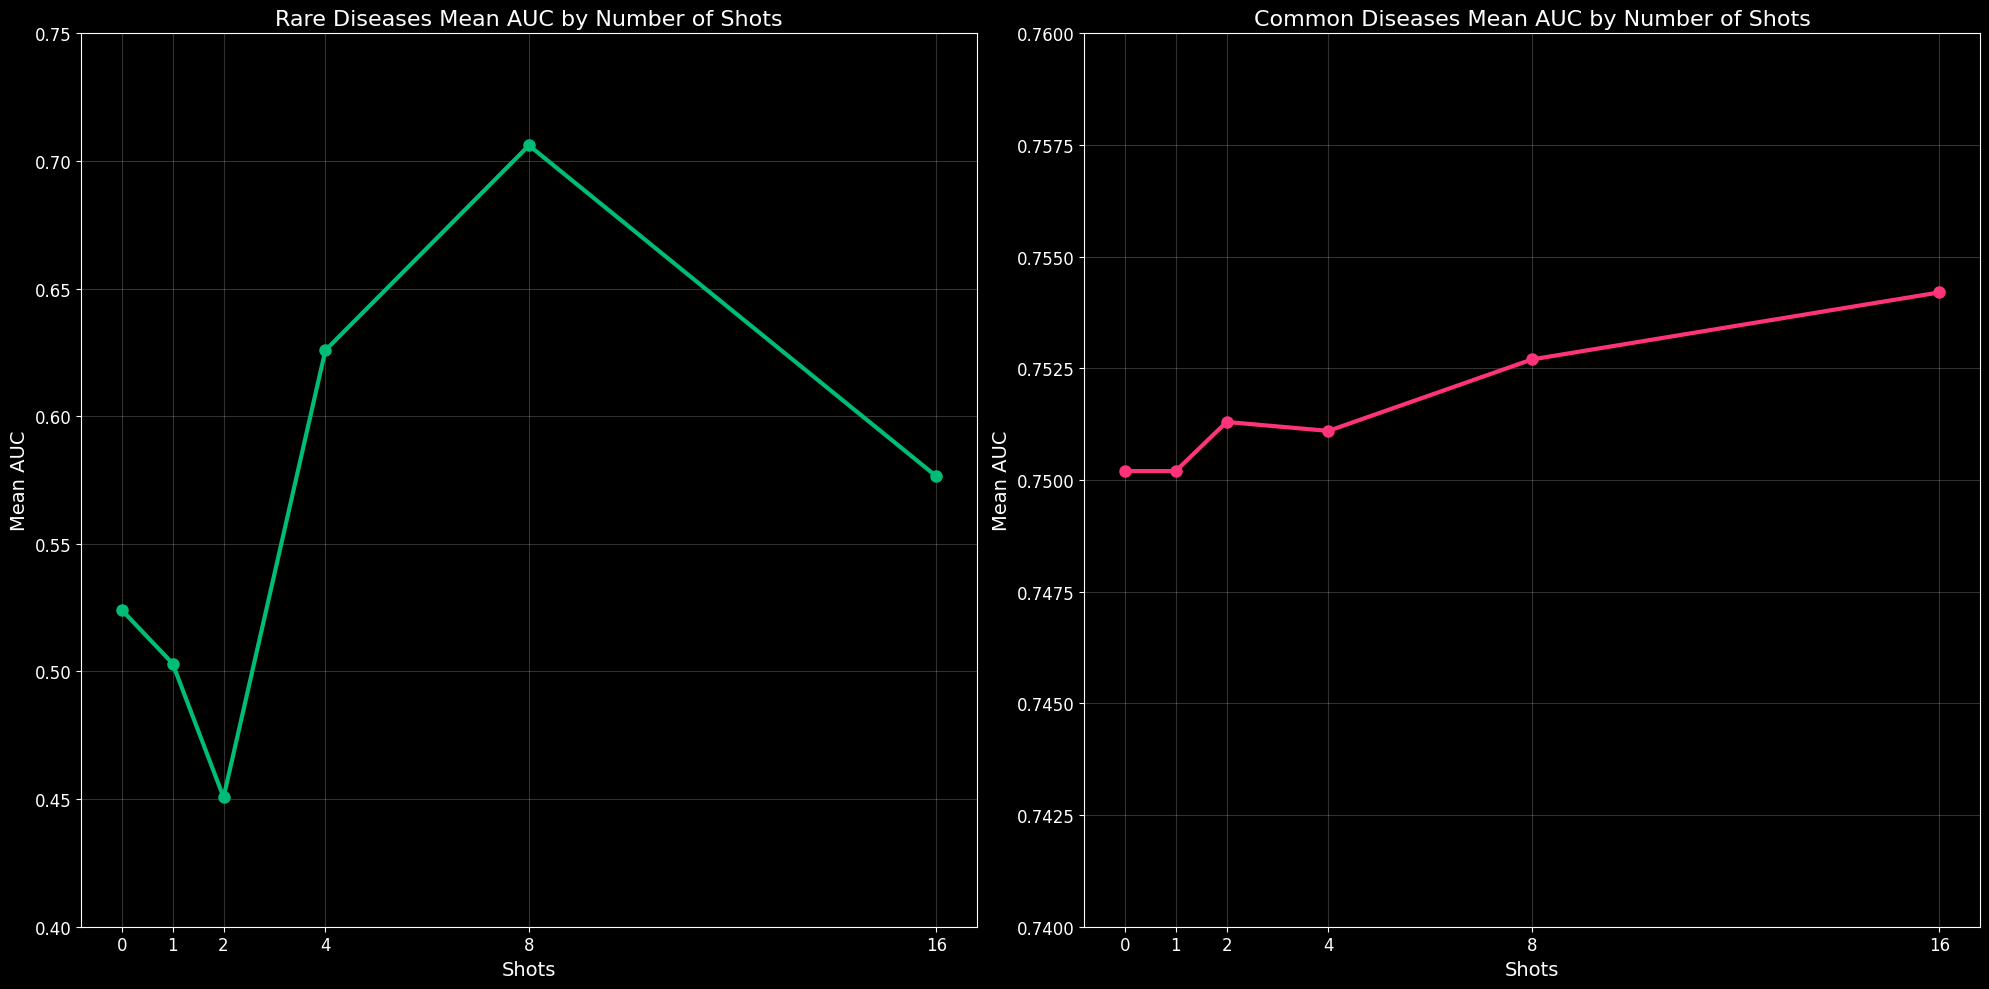

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')
shots = ['zero-shot', '1-shot', '2-shot', '4-shot', '8-shot', '16-shot']
x_numeric = [0, 1, 2, 4, 8, 16]  

rare_mean_aucs = {
    'zero-shot': 0.5241,
    '1-shot': 0.5031,
    '2-shot': 0.4507,
    '4-shot': 0.6258,
    '8-shot': 0.7061,
    '16-shot': 0.5765
}

common_mean_aucs = {
    'zero-shot': 0.7502,
    '1-shot': 0.7502,
    '2-shot': 0.7513,
    '4-shot': 0.7511,
    '8-shot': 0.7527,
    '16-shot': 0.7542
}

rare_means = [rare_mean_aucs[shot] for shot in shots]
common_means = [common_mean_aucs[shot] for shot in shots]

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(x_numeric, rare_means, 'o-', linewidth=3, color='#00bd76', markersize=8)
plt.title('Rare Diseases Mean AUC by Number of Shots', fontsize=16)
plt.xlabel('Shots', fontsize=14)
plt.ylabel('Mean AUC', fontsize=14)
plt.grid(True, alpha=0.2)
plt.xticks(x_numeric, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.4, 0.75)

plt.subplot(1, 2, 2)
plt.plot(x_numeric, common_means, 'o-', linewidth=3, color='#ff337a', markersize=8)
plt.title('Common Diseases Mean AUC by Number of Shots', fontsize=16)
plt.xlabel('Shots', fontsize=14)
plt.ylabel('Mean AUC', fontsize=14)
plt.grid(True, alpha=0.2)
plt.xticks(x_numeric, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.74, 0.76)  

plt.tight_layout()
plt.savefig('dark_mode_auc_progression.png', dpi=300)
plt.show()

In [1]:
from IPython.display import display, HTML
import pandas as pd

data = {
    'Pathology': [
        'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
        'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural Thickening', 'Cardiomegaly', 'Nodule',
        'Mass', 'Hernia'
    ],
    'CheXZero': [0.758, 0.783, 0.642, 0.764, 0.689, 0.665, 0.575, 0.738, 0.726, 0.639, 0.825, 0.494, 0.623, 0.591],
    'ImCLIP': [0.484, 0.619, 0.619, 0.553, 0.680, 0.473, 0.593, 0.653, 0.620, 0.573, 0.576, 0.549, 0.426, 0.404],
    'CXRCLIP': [0.790, 0.780, 0.690, 0.860, 0.910, 0.340, 0.660, 0.770, 0.750, 0.640, 0.661, 0.600, 0.700, 0.830],
    'MoCoCLIP': [0.700, 0.780, 0.730, 0.790, 0.890, 0.530, 0.670, 0.770, 0.770, 0.700, 0.740, 0.530, 0.580, 0.850],
    'My Version': [0.7050, 0.6985, 0.6920, 0.8033, 0.8154, 0.8222, 0.7811, 0.7718, 0.6674, 0.7192, 0.8042, 0.6800, 0.6879, 0.8546]
}

df = pd.DataFrame(data)

avg_row = df.drop(columns='Pathology').mean(numeric_only=True).to_frame().T
avg_row['Pathology'] = 'Average AUC'
df = pd.concat([df, avg_row], ignore_index=True)

df = df.round(3)

df = df[['Pathology', 'CheXZero', 'ImCLIP', 'CXRCLIP', 'MoCoCLIP', 'My Version']]

def highlight_max_bold(s):
    if s.name == 'Average AUC':
        return [''] * len(s)
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_table_bold = df.style.set_caption("AUC Comparison vs SOTA")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center'), ('font-weight', 'bold'), ('font-family', 'Times New Roman')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Times New Roman')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-family', 'Times New Roman')]}
    ])\
    .apply(highlight_max_bold, axis=1, subset=df.columns[1:])\
    .format(precision=3)\
    .hide(axis="index")

styled_table_heatmap = df.style.set_caption("AUC Comparison vs SOTA (Heatmap)")\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center'), ('font-weight', 'bold'), ('font-family', 'Times New Roman')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'Times New Roman')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-family', 'Times New Roman')]}
    ])\
    .background_gradient(cmap='YlGnBu', axis=1, low=0.1, high=0.9, subset=df.columns[1:])\
    .format(precision=3)\
    .hide(axis="index")

display(HTML(styled_table_bold.to_html()))
display(HTML("<br><hr><br>"))  # Spacer between tables
display(HTML(styled_table_heatmap.to_html()))


Pathology,CheXZero,ImCLIP,CXRCLIP,MoCoCLIP,My Version
Atelectasis,0.758,0.484,0.790,0.700,0.705
Consolidation,0.783,0.619,0.780,0.780,0.698
Infiltration,0.642,0.619,0.690,0.730,0.692
Pneumothorax,0.764,0.553,0.860,0.790,0.803
Edema,0.689,0.680,0.910,0.890,0.815
Emphysema,0.665,0.473,0.340,0.530,0.822
Fibrosis,0.575,0.593,0.660,0.670,0.781
Effusion,0.738,0.653,0.770,0.770,0.772
Pneumonia,0.726,0.620,0.750,0.770,0.667
Pleural Thickening,0.639,0.573,0.640,0.700,0.719


Pathology,CheXZero,ImCLIP,CXRCLIP,MoCoCLIP,My Version
Atelectasis,0.758,0.484,0.790,0.700,0.705
Consolidation,0.783,0.619,0.780,0.780,0.698
Infiltration,0.642,0.619,0.690,0.730,0.692
Pneumothorax,0.764,0.553,0.860,0.790,0.803
Edema,0.689,0.680,0.910,0.890,0.815
Emphysema,0.665,0.473,0.340,0.530,0.822
Fibrosis,0.575,0.593,0.660,0.670,0.781
Effusion,0.738,0.653,0.770,0.770,0.772
Pneumonia,0.726,0.620,0.750,0.770,0.667
Pleural Thickening,0.639,0.573,0.640,0.700,0.719
